In [1]:
import os
import sys
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2025-01-02 01:08:01


In [2]:
from pynext.system_of_units import *

In [3]:
from pynext.xetd import Xenon, CXe

In [4]:
from pynext.TpcEL import  TpcEL
from pynext.CylindricalVessel import CylindricalDetector

In [5]:
from pynext.CylinderGeomEff import barrel_detection_efficiency

In [6]:
import pynext.pynext_types as pn

# Functions 

In [7]:
def fdcvst(m, b):
    def dvcst(t):
        return b + m * t
    return dvcst

In [8]:
def dc_mm2(t):
    """
    Get the DC rate per mm2, using Hamamatsu data
    the S13360 series has size 3 x 3 mm2, thus we divide by 9 to get DC
    
    """
    ldc = logdc_vs_t(t)/9
    return np.exp(ldc)/9
    

In [9]:
def set_fonts(ax, fontsize=20):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

def display_figure(x, y, lbx, lby, log=False, xlim=None, ylim=None, xl=None, yl=None,
                   lw=2, fontsize=20, figsize=(8,8)):

    fig = plt.figure(figsize=figsize)
    ax      = fig.add_subplot(1, 1, 1)

    set_fonts(ax, fontsize=fontsize)
    if log == 'logy':
        plt.semilogy(x, y, linewidth=lw)
    elif log == 'loglog':
        plt.loglog(x, y, linewidth=lw)
    else:
        plt.plot(x, y, linewidth=lw)
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
    if yl:
        plt.axhline(y=yl,linestyle='dashed', color='k',linewidth=lw)
    if xl:
        plt.axvline(x=xl,linestyle='dashed', color='k',linewidth=lw)
    plt.xlabel(lbx)
    plt.ylabel(lby)
    plt.show()


def display_figures(xs, ys, lbx, lby, log=False, xlim=None, ylim=None, xl=None, yl=None,
                   lw=2, fontsize=20, figsize=(8,8)):

    fig = plt.figure(figsize=figsize)
    ax      = fig.add_subplot(1, 1, 1)

    set_fonts(ax, fontsize=fontsize)
    for i, x in enumerate(xs):
        y = ys[i]
        if log == 'logy':
            plt.semilogy(x, y, linewidth=lw)
        elif log == 'loglog':
            plt.loglog(x, y, linewidth=lw)
        else:
            plt.plot(x, y, linewidth=lw)
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
    if yl:
        plt.axhline(y=yl,linestyle='dashed', color='k',linewidth=lw)
    if xl:
        plt.axvline(x=xl,linestyle='dashed', color='k',linewidth=lw)
    plt.xlabel(lbx)
    plt.ylabel(lby)
    plt.show()

In [10]:
kHz = kilohertz
MHz = megahertz

# HD 
- Consider two versions of HD. "HD in Blue" (TPB) and "HD in (ultra) Violet" (no TPB).
- The HDB (HD in Blue) design includes a Barrel of Fiber Detector (BFD) and a standard tracking plane (STP) with a pitch of 10 mm
- The VHD (HD in VUV) considers several possibilities. 
    - A STP for tracking and a Silicon Barrel Detector (SBD) for energy measurement.
    - A Dense Tracking Plane (DTP) fulfilling both functions. 

- In both cases one can choose between operating at 20C (and cooling SiPMs) or operate with cool gas. The election of cool gas is more natural for VHD, where the amount of SiPMs is huge. 


## Dark Current considerations

### Hamamatsu data S13360 series

In [11]:
tC = np.array([-10,0,  10,  20,  30,   40,   50])  # in C
dR = np.array([ 10,30, 90, 250, 750, 2000, 6000]) # in kHz
ldR = np.log(dR)

In [12]:
coeffs = np.polyfit(tC, ldR, deg=1)
mx, bx = coeffs
print("Slope (m):", mx)
print("Intercept (b):", bx)

Slope (m): 0.10610879520574422
Intercept (b): 3.3986160211895924


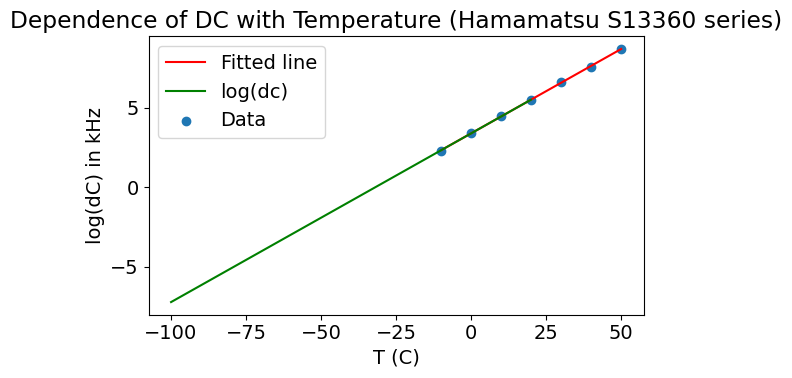

In [13]:
y_fit = np.polyval(coeffs, tC)  # fitted function 
logdc_vs_t = fdcvst(mx, bx)       # function with coefficients (another version of fitted)
xx = np.arange(-100, 20, 0.1)
yy = logdc_vs_t(xx)

# Plot data and fitted line
fig, axs = plt.subplots(1, 1, figsize=(6,4))
axs.scatter(tC, ldR, label='Data')
axs.plot(tC, y_fit, 'r-', label='Fitted line')
axs.plot(xx, yy, 'g-', label='log(dc)')
axs.legend()
axs.set_title("Dependence of DC with Temperature (Hamamatsu S13360 series)")
axs.set_xlabel("T (C)")
axs.set_ylabel("log(dC) in kHz")
fig.tight_layout()
plt.show()

## HD at -40 C (same density at 15 bar than 20 bar at 20 C). 

In [14]:
dcm40 =dc_mm2(-40) * kHz
print(f"DC/mm2 of Silicon at -40 C = {dcm40/hertz} hertz")

DC/mm2 of Silicon at -40 C = 101.14549842222382 hertz


## Detector dimensions

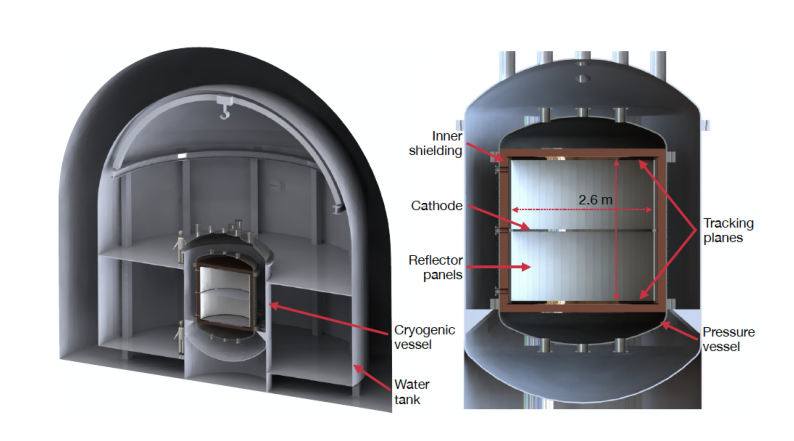

In [15]:
img = mpimg.imread('hd.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

- The detector above shows the design of a cooled gas symmetric HPXe. 
- The longitudinal dimensions are constrained by the voltage at the anode and the lifetime. NEXT-100 measures a very long lifetime. The constrains on HV are computed below.

In [16]:
tpcel = TpcEL(EP = 1.5 * kilovolt / (cm * bar),
                 dV = 0.4 * kilovolt / cm,
                 P  =  20 * bar,
                 d  =   5 * mm,
                 L  = 150 * cm,
                 Ws =  24 * eV,
                 Wi =  16 * eV)

In [17]:
tpcel


        E/P =    1.50 kV * cm^-1* bar^-1
        dV = drift voltage =    0.40 kV * cm^-1
        P  = pressure =   20.00 bar
        d  = EL grid gap =    5.00 mm
        L  = drift lenght =   1.50 m
        Grid voltage =   15.00 kV
        Cathode voltage =   75.00 kV
        Yield =  9.40e+02 photons/e

    
        Primary scintillation photons per MeV = 4.1667e+04
        Primary ionization electrons per MeV = 6.2500e+04
        EL photons per MeV                   = 5.8750e+07
        

- Assuming an effective pressure of 20 bar (same density than 15 bar at -40 C) the cathode voltage needs to be operated at 75 kV and the grids at 15 kV. These are challenging parameters. Not impossible but require R&D and demonstrators. 

In [18]:
tpcel2 = TpcEL(EP = 1.5 * kilovolt / (cm * bar),
                 dV = 0.4 * kilovolt / cm,
                 P  =  20 * bar,
                 d  =   5 * mm,
                 L  = 110 * cm,
                 Ws =  24 * eV,
                 Wi =  16 * eV)

In [19]:
tpcel2


        E/P =    1.50 kV * cm^-1* bar^-1
        dV = drift voltage =    0.40 kV * cm^-1
        P  = pressure =   20.00 bar
        d  = EL grid gap =    5.00 mm
        L  = drift lenght =   1.10 m
        Grid voltage =   15.00 kV
        Cathode voltage =   59.00 kV
        Yield =  9.40e+02 photons/e

    
        Primary scintillation photons per MeV = 4.1667e+04
        Primary ionization electrons per MeV = 6.2500e+04
        EL photons per MeV                   = 5.8750e+07
        

- Alternatively, one can operate the system at 60/15 kV, which is less demanding but requires  a detector of larger radius

In [20]:
gxe15 = Xenon('xe_15m40')
print(gxe15)


        material                                   = xe_15m40
        density (rho)                              =    0.13 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0049 cm^-1
        attenuation length (Latt)                  =   2e+02 cm
    


### Xenon Volume

#### Assuming L = 150 cm (per TPC)

In [21]:
Rg = 100 * cm
Lg = 300 * cm
Dg = 2 * Rg
gxetd = CXe(gxe15, R=Rg, L=Lg, Rb=1*cm, Cb=1*cm, Ab=1*cm)
gxetd


        
        material                                   = xe_15m40
        density (rho)                              =    0.13 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0049 cm^-1
        attenuation length (Latt)                  =   2e+02 cm
    
        
        Fiducial Radius =  100.00 cm  xe Radius =  101.00 cm
        Fiducial Length =  300.00 cm  Xe Length =  302.00 cm
        
        Fiducial Volume =    9.42 m3 Xe Volume =    9.68 m3
        Fiducial mass = 1187.52 kg Xe mass = 1219.47 kg
        
        Radial buffer radius =    1.00 cm (E/P ~ 2)
        Cathode buffer thickness =    1.00 cm   (E/P~1)
        Anode buffer thickness =    1.00 cm
        
        Long buffer Volume =    0.19 m3
        Long buffer mass =   24.03 kg
        
        Cathode buffer Volume =    0.03 m3
        Cathode buffer mass =    4.04 kg
        
        Anode buffer Volume =    0.03 m3
        Ano

#### Assuming L=110 cm per TPC

In [22]:
Rg = 110 * cm
Lg = 220 * cm
Dg = 2 * Rg
gxetd = CXe(gxe15, R=Rg, L=Lg, Rb=1*cm, Cb=1*cm, Ab=1*cm)
gxetd


        
        material                                   = xe_15m40
        density (rho)                              =    0.13 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =  0.0049 cm^-1
        attenuation length (Latt)                  =   2e+02 cm
    
        
        Fiducial Radius =  110.00 cm  xe Radius =  111.00 cm
        Fiducial Length =  220.00 cm  Xe Length =  222.00 cm
        
        Fiducial Volume =    8.36 m3 Xe Volume =    8.59 m3
        Fiducial mass = 1053.73 kg Xe mass = 1082.73 kg
        
        Radial buffer radius =    1.00 cm (E/P ~ 2)
        Cathode buffer thickness =    1.00 cm   (E/P~1)
        Anode buffer thickness =    1.00 cm
        
        Long buffer Volume =    0.15 m3
        Long buffer mass =   19.42 kg
        
        Cathode buffer Volume =    0.04 m3
        Cathode buffer mass =    4.88 kg
        
        Anode buffer Volume =    0.04 m3
        Ano

- We fixed the dimensions to this compromise: L=110 cm (per TPC), R= 110 cm (D = 220 cm)

## SiPM Detector

In [23]:
print(f"End-cap surface to be instrumented = {gxetd.readoutSurface/m2} m2")

End-cap surface to be instrumented = 3.8707563084879837 m2


In [24]:
print(f"Barrel surface to be instrumented = {gxetd.longReadoutSurface/m2} m2")

Barrel surface to be instrumented = 15.34353852013255 m2


- nEXO design for barrel: 1 x 1 cm2 SiPMs, grouped in 6 x 1 cm2 readout. 
- DTP nEXT style. Full coverage, SiPMs of 1 x 1 cm2 at a pitch of 1 cm.

### Case 1: Barrel a la nEXO and STP
- bSiPM are barrel SiPMs (10 x 10 mm2)
- tSiPM are "tracking" SiPMs (1 x 1 mm2)

In [25]:
bSiPM_area = 100 * mm2
tSiPM_area = 100 * mm2
bDet_area = gxetd.longReadoutSurface
nbSiPM = bDet_area/bSiPM_area
print(f"Number of SiPMs (10 x 10 mm2) in Barrel = {nbSiPM:.2g}")

Number of SiPMs (10 x 10 mm2) in Barrel = 1.5e+05


In [26]:
tSiPM_eff_area = 100 * mm2  # This is because there is 1 SipM at 10 mm pitch 
tDet_area = gxetd.readoutSurface
ntSiPM = 2*tDet_area/tSiPM_eff_area # 2 tracking planes
print(f"Number of SiPMs (1 x 1 mm2) in End-Cup (tracking) = {ntSiPM:.2g}")

Number of SiPMs (1 x 1 mm2) in End-Cup (tracking) = 7.7e+04


#### Cost of Blue SiPMs (From Hamamatsu offers)

In [27]:
sipm_6x6_4x4 = 223 #e
sipm_6x6_4x4_units = 16
sipm_6x6_cost = sipm_6x6_4x4/sipm_6x6_4x4_units
sipm_cost_mm2 = sipm_6x6_cost/36
print(f"Hamamatsu: cost SiPMs 6x6  per channel = {sipm_6x6_cost:.2f}, per mm^2 = {sipm_cost_mm2:.2f}")


Hamamatsu: cost SiPMs 6x6  per channel = 13.94, per mm^2 = 0.39


In [28]:
sipm_3x3_8x8 = 223 #e
sipm_3x3_8x8_units = 64
sipm_3x3_cost = sipm_3x3_8x8/sipm_3x3_8x8_units
sipm_cost_mm2 = sipm_3x3_cost/9
print(f"Hamamatsu: cost SiPMs 3x3 = {sipm_3x3_cost:.2f}, per mm^2 = {sipm_cost_mm2}")

Hamamatsu: cost SiPMs 3x3 = 3.48, per mm^2 = 0.3871527777777778


- Thus cost of SiPMs (Blue) per mm2 is 0.39 euros. Cost is strictly proportional to surface

#### Cost of VUV SiPMS (from Hamamatsu offer)

In [29]:
sipm_6x6_4x4 = 1705 #e
sipm_6x6_4x4_units = 16
sipm_6x6_cost = sipm_6x6_4x4/sipm_6x6_4x4_units
sipm_vuv_cost_mm2 = sipm_6x6_cost/36
print(f"Hamamatsu: cost VUV SiPMs 6x6  per channel = {sipm_6x6_cost:.2f}, per mm^2 = {sipm_vuv_cost_mm2:.2f}")


Hamamatsu: cost VUV SiPMs 6x6  per channel = 106.56, per mm^2 = 2.96


In [30]:
print(f"Ratio VUV/Blue = {sipm_vuv_cost_mm2/sipm_cost_mm2}")

Ratio VUV/Blue = 7.645739910313901


### Dark Current 
- In this case, we only need to worry about the DC in the barrel detector, which measures energy

In [31]:
dc_barrel = dcm40 * bDet_area/mm2
print(f"DC in the barrel = {dc_barrel/MHz} MHz")

DC in the barrel = 1551.9298511793972 MHz


### Signal (in pes) as a function of energy
- First we compute the geometrical efficiency (e.g, probability of a photon generated in the xenon volume to hit the barrel detector). We use a simple geometrical calculation. 
- The Detection efficiency of Hamamatsu SiPMs varies between 30-40 %. Let's assume for simplicity 30-50% for all the SiPMs (VUV and Blue). This is rather correct, since in the case of Blue SiPMs one has to multiply by TPB absorption efficiency. 
- We multiply the number of scintillation photons (for a given energy) by the efficiency factors and compare with Dark Current. 
- To compare with DC we need to compute the DC in the time that we need to record the S1 from the SiPM. We take that integration time as 0.5 mus

In [32]:
eff_geom = barrel_detection_efficiency(Rg, Lg/2) # L in the equation is semilength 
print(f"Geometrical efficiency = {eff_geom}")

Geometrical efficiency = 0.8536776763694542


In [33]:
eff_det = 0.3  
print(f"Detection efficiency = {eff_det}")

Detection efficiency = 0.3


### Krypton

In [34]:
print(f" Scintillation photons for Krypton ={tpcel2.ScintillationPhotons(45*keV)}")

 Scintillation photons for Krypton =1874.9999999999998


In [35]:
nsKr = tpcel2.ScintillationPhotons(45*keV) * eff_det * eff_geom 
print(f" Detected Scintillation photons for Krypton ={nsKr:.1f}")

 Detected Scintillation photons for Krypton =480.2


In [36]:
ndC =500*1e-9*dc_barrel/hertz
print(f" DC in barrel at -40 C in integration window of 0.5 mus ={ndC:.1f}")

 DC in barrel at -40 C in integration window of 0.5 mus =776.0


#### Kr cannot be detected due to DC

#### Na22

In [37]:
nNa = tpcel2.ScintillationPhotons(511*keV) * eff_det * eff_geom 
print(f" Scintillation photons for Na-22 ={nNa}")
print(f" S/N for Na-22 ={nNa/ndC:.2f}")

 Scintillation photons for Na-22 =5452.866157809889
 S/N for Na-22 =7.03


### Energy resolution

In [38]:
nEL = tpcel2.ELPhotons(2500*keV) * eff_det * eff_geom * 0.5 # (only photons going backwards)
print(f"number of EL photons detected = {nEL/1E+6} (M photons)")
print(f" relative resolution fluctuations = {100/np.sqrt(nEL):.2g} %")

number of EL photons detected = 18.807586307514537 (M photons)
 relative resolution fluctuations = 0.023 %


**Plenty of light, no issues with energy resolution, full barrel detector should result in smooth geometrical corrections easy to calibrate**

### Cost of Barrel Detector

In [39]:
cbdVUV = sipm_vuv_cost_mm2 * bDet_area/mm2
print(f"Cost of the Barrel SiPMs (VUV) = {cbdVUV/1e+6} M$")

Cost of the Barrel SiPMs (VUV) = 45.417939543100694 M$


In [40]:
cbdB = sipm_cost_mm2 * bDet_area/mm2
print(f"Cost of the Barrel SiPMs (Blue) = {cbdB/1e+6} M$")

Cost of the Barrel SiPMs (Blue) = 5.940293559009651 M$


### Number of channels
- According to nEXO, SiPMs are ganged in groups of 6. The number of readout channels is thus the number of SiPMs divided by 6. We assume a cost of 10 $ per readout channel. 

In [41]:
nbChanels = nbSiPM/6 
print(f"Number of channels in Barrel = {nbChanels:.1f}, cost = {10*nbChanels/1E+6} M$")

Number of channels in Barrel = 25572.6, cost = 0.25572564200220915 M$


**Thus, the cost of SiPMs is dominant, with a big factor associated to using VUV SiPMs.** 

### Cost of STP (Tracking standard)

In [42]:
ctVUV = 0.1 * sipm_vuv_cost_mm2 * tDet_area/mm2 # factor 0.1 comes because of pitch at 10 mm
print(f"Cost of the Tracking SiPMs (VUV) = {ctVUV/1e+6} M$")

Cost of the Tracking SiPMs (VUV) = 1.1457707475645857 M$


In [43]:
ctB = 0.1 * sipm_cost_mm2 * tDet_area/mm2 # factor 0.1 comes because of pitch at 10 mm
print(f"Cost of the Tracking SiPMs (VUV) = {ctB/1e+6} M$")

Cost of the Tracking SiPMs (VUV) = 0.149857405693198 M$


## HD at -50

In [44]:
dcm50 =dc_mm2(-50) * kHz
print(f"DC/mm2 of Silicon at -50 C = {dcm50/hertz} hertz")
print(f"DC ratio -50/-40  = {dcm50/dcm40}")

DC/mm2 of Silicon at -50 C = 89.89671473862123 hertz
DC ratio -50/-40  = 0.8887861164453861


**Not worth to go to lower temperature (maximum pressure of 10 bar, much less density).**

## Conclusions: HD with Silicon Barrel

- Requires operation at -40 C. Almost certainly requires to cool the gas, given enormous power to evacuate and complexity of doing it with thermal links. 
- Krypton cannot be observed due to DC, but with sufficient lifetime, operation should be OK using diffusion. 
- Energy resolution should be good.
- STP is affordable, even using VUV. 
- SBD is very expensive in VUV using today's prices (quotes to PETALO). Feasibility depends on being able to reduce cost of SiPMs.
- Interestingly a "Blue" detector (using TPB) is also a possibility and is way more affordable. Thus, one could contemplate a "Blue" module for HD and a "VUV" module for BOLD.
- Cost is not everything. This solution adds the complexity of cool gas, and instrumenting 15 m2 with SiPMs (only for the barrel). 

## Dense Silicon Plane

- In this case the detector has a light tube not coated with TPB, and the DSP performs the function of tracker and energy system.
- Consider first the scenario of full coverage. The end-caps are fully tiled with SiPMs of 10x10 mm2 at a pitch of 10 mm. From the point of view of tracking this is equivalente to a STP, but the detector also doubles as a calorimeter.

In [45]:
dtp_area = 2 * tDet_area
cdtpVUV = sipm_vuv_cost_mm2 * dtp_area/mm2
print(f"Cost of the DTP SiPMs (VUV) = {cdtpVUV/1e+6} M$")
cdtpB = sipm_cost_mm2 * dtp_area/mm2
print(f"Cost of the DTP SiPMs (Blue) = {cdtpB/1e+6} M$")

Cost of the DTP SiPMs (VUV) = 22.91541495129171 M$
Cost of the DTP SiPMs (Blue) = 2.9971481138639597 M$


In [46]:
ndtpSiPM = 2*tDet_area/tSiPM_area # 2 tracking planes
print(f"Number of SiPMs (10 x 10 mm2) in End-Cup (tracking) = {ndtpSiPM:.2g}")
print(f"Cost of electronics assuming 10 $ per channel in DTP = {ndtpSiPM*10:.2g} $")

Number of SiPMs (10 x 10 mm2) in End-Cup (tracking) = 7.7e+04
Cost of electronics assuming 10 $ per channel in DTP = 7.7e+05 $


### Observing Kr
- The probability of observing a scintillation photon is the complementary to the probability of observing such photons in the barrel (to first approximation, since the light tube is not very reflective for VUV).

In [47]:
eff_dtp_geom = 1- barrel_detection_efficiency(Rg, Lg/2) # L in the equation is semilength 
print(f"Geometrical efficiency for DTP = {eff_dtp_geom}")

Geometrical efficiency for DTP = 0.14632232363054576


In [48]:
nsDTPKr = tpcel2.ScintillationPhotons(45*keV) * eff_det * eff_dtp_geom 
print(f" Detected Scintillation photons for Krypton ={nsDTPKr:.1f}")

 Detected Scintillation photons for Krypton =82.3


In [49]:
dc_dtp = 2 * dcm40 * tDet_area/mm2
print(f"DC in the DTP = {dc_dtp/MHz} MHz")

DC in the DTP = 783.0191521859687 MHz


In [50]:
nDTPdC =500*1e-9*dc_dtp/hertz
print(f" DC in barrel at -40 C in integration window of 0.5 mus ={nDTPdC:.1f}")

 DC in barrel at -40 C in integration window of 0.5 mus =391.5


In [51]:
nsDTPNa = tpcel2.ScintillationPhotons(511*keV) * eff_det * eff_dtp_geom 
print(f" Detected Scintillation photons for Na22 ={nsDTPNa:.1f}")
print(f" Ratio Na22/DC ={nsDTPNa/nDTPdC:.1f}")

 Detected Scintillation photons for Na22 =934.6
 Ratio Na22/DC =2.4


## Conclusions: HD with Silicon Barrel

- Requires operation at -40 C. Almost certainly requires to cool the gas, given enormous power to evacuate and complexity of doing it with thermal links. 
- Krypton cannot be observed due to DC, but with sufficient lifetime, operation should be OK using diffusion. 
- Energy resolution should be good.
- DTP is expensive, but less so than Barrel. Feasibility depends on being able to reduce cost of SiPMs, but less dramatically.
- Interestingly a "Blue" detector (using TPB) is also a possibility and is way more affordable. Thus, one could contemplate a "Blue" module for HD and a "VUV" module for BOLD.
- Cost is not everything. This solution adds the complexity of cool gas, and instrumenting 7 m2 with SiPMs.

## Electronics
- The electronics needs to have a sampling rate of at most 500 ns for S1 detection. 
- Each half TPC is 1.2 m long, or about 1200 mus. Thus one needs 2400 samples per channel. 
- Thus the total number of samples is very large ~1.9e+8. Electronics must implement a zero suppression mode

In [52]:
xns = 2400 * ndtpSiPM
print(f"nsamples = {xns:.2g}")

nsamples = 1.9e+08


## HD Based on fibers

In [53]:
EP  = 3.5 * kilovolt / (cm * bar)
dV  = 0.5 * kilovolt / cm
P   =  15 * bar
d   =   5 * mm
L   = 120 * cm
Ws  =  39.2 * eV
Wi  =  21.9 * eV
hdel = pn.TpcEL(EP, dV, P, d, L, Ws, Wi)
hdel


        E/P =    3.50 kV * cm^-1* bar^-1
        dV = drift voltage =    0.50 kV * cm^-1
        P  = pressure =   15.00 bar
        d  = EL grid gap =    5.00 mm
        L  = drift lenght =   1.20 m
        Grid voltage =   26.25 kV
        Cathode voltage =   86.25 kV
        Yield =  2.80e+03 photons/e

    
        Primary scintillation photons per MeV = 2.55e+04
        Primary ionization electrons per MeV = 4.57e+04
        EL photons per MeV                   = 1.28e+08
        
        Primary scintillation Krypton = 1.06e+03
        Primary ionization electrons Krypton = 1.89e+03
        EL photons Krypton                   = 5.32e+06
        
        Primary scintillation Qbb = 6.27e+04
        Primary ionization electrons Qbb = 1.12e+05
        EL photons Qbb                   = 3.15e+08
        

In [54]:
r = 1.2
Rg = 110 * cm
zmin = 0 * cm
zmax = 220 * cm
cl = pn.Cylinder(Rg, zmin, zmax)
hdxe = pn.TpcXe(cl, "Xenon", 20*bar)
hdxe


        material       = Xenon
        density (rho)  =    0.12 g/cm3
        mass           = 1039.51  kg
        Cylinder       = Cylinder(r=1100.0, zmin=0.0, zmax=2200.0)
    

In [55]:
tpb = pn.WLS("TBP", 0.65)

In [56]:
fwls = pn.FiberWLS(d = 1*mm, wls = tpb, qfib = 0.85, qptfe=0.98, ncore = 1.6, nclad1 = 1.49, nclad2 = 1.42, latt = 3.5*m)
fwls


        diameter =1.0 mm, Q = 0.85, PTFE refl = 0.98
        ncore = 1.6, nclad1 =1.49, nclad2 =1.42
        Absoprtion prob at 450 nm     = 0.6692690255200586
        Trapping efficieny            = 0.09837038590604039
        Fiber coated with WLS         = TBP
        WLS QE                        = 0.65

    

In [60]:
s13360 = pn.SiPM(name='s13360', xsize=1*mm, PDE = 0.4, C = 150*pF, Rs=100*ohm)
s13360


        sensor =s13360, size = 1.0 mm, PDE = 0.4
        capacitance = 150.00 pF;
        

In [63]:
fdHD = pn.FiberDetector(hdel, hdxe, fwls, s13360, eff_t=0.85, sampling= 500 * ns, adcPerPes=15, tempC=-40)
fdHD


        gas pressure  =   20.00 bar
        gas density   =    0.12 g/cm3
        gas mass      = 1039.51  kg

        Dimensions(Cylinder)  = Cylinder(r=1100.0, zmin=0.0, zmax=2200.0)

        Fibers efficiency = 3.97 %
        of which: Transport = 0.05434963821308731 % & attenuation = 0.7303103382513573 %
        SiPM PDE          = 0.40
        SiPM size         = 1.00 mm
        fiber size        = 1.00 mm
        Sampling S1       = 500.00 ns
        ADC counts 1 PE   = 15
        number of fibers  = 6912

        Primary scintillation Krypton          = 1.06e+03
        EL photons Krypton                     = 5.32e+06
        Primary scintillation Qbb              = 6.27e+04
        EL photons Qbb                         = 3.15e+08

        Primary scintillation Krypton detected = 1.68e+01
        EL photons Krypton detected            = 8.44e+04
        Primary scintillation Qbb detected     = 9.96e+02
        EL photons Qbb detected                = 5.00e+06

        Primary

In [70]:
area_si_mm2 = np.pi*(fwls.diameter/2)**2* fdHD.n_fibers/mm2
area_si_m2 = np.pi*(fwls.diameter/2)**2* fdHD.n_fibers/m2
print(f"area of silicon readout for fibers = {area_si_mm2} mm2")
print(f"area of silicon readout for fibers in m2= {area_si_m2} m2")

area of silicon readout for fibers = 5428.672105403162 mm2
area of silicon readout for fibers in m2= 0.005428672105403163 m2


In [69]:
dcsif = 500*1e-9*dcm40/hertz * area_si_mm2
print(f"total DC silicon readout = {dcsif} hertz")

total DC silicon readout = 0.27454287293591306 hertz


## Conclusions: HD with Fibers

- Requires operation at -40 C. Does not require to cool the gas, since the number of readout SiPMs for fibers is small and can be accomodated in a cooling ring. 
- Krypton can be observed
- Energy resolution should be good.
- BFD cost is a small fraction of any detector based on SiPMs.
- The BFD is a much simpler detector than DTP or BSD.